Лабораторная работа №5. Применение сверточных нейронных сетей (бинарная классификация)
======
Данные: Набор данных DogsVsCats, который состоит из изображений различной размерности, содержащих фотографии собак и кошек. Обучающая выборка включает в себя 25 тыс. изображений (12,5 тыс. кошек: cat.0.jpg, …, cat.12499.jpg и 12,5 тыс. собак: dog.0.jpg, …, dog.12499.jpg), а контрольная выборка содержит 12,5 тыс. неразмеченных изображений. Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте Kaggle -> https://www.kaggle.com/c/dogs-vs-cats/data


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

#### Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.

In [8]:
import zipfile


zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("../input/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [9]:
train_dir = 'train'
test_dir = 'test1'

In [10]:
files_labels = {os.path.join(train_dir, file_name): 0 if 'cat' in file_name else 1 
              for file_name in os.listdir(train_dir)}
data = pd.DataFrame.from_dict({'image_file': list(files_labels.keys()), 'label': list(files_labels.values())})

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)
test_data, val_data = train_test_split(test_data, test_size=0.25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d072c90f0>]],
      dtype=object)

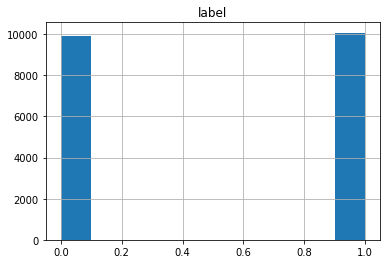

In [12]:
train_data.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d62f58240>]],
      dtype=object)

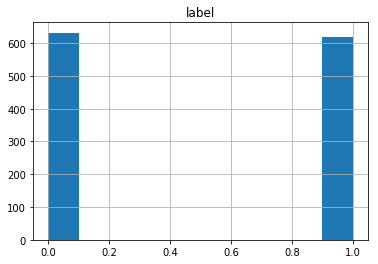

In [13]:
val_data.hist()

In [73]:
class CatDogDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img = Image.open(file)
        if self.transform:
            img = self.transform(img)
        
        img = img.numpy()
        return img.astype('float32'), label

In [15]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = CatDogDataset(train_data, transform = data_transform)
val_dataset = CatDogDataset(val_data, transform = data_transform)

In [16]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False, num_workers=4)

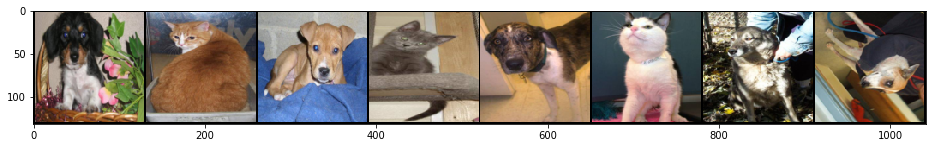

In [17]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:8])
np_grid_imgs = grid_imgs.cpu().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

#### Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. 

In [80]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc_preout = nn.Linear(4096, 100)
        self.fc = nn.Linear(100, 2) 

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_preout(out)
        out = self.fc(out)

        return out

In [43]:
def validate(model, val_loader, criterion):         
    correct = 0
    total = 0
    total_loss = 0
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = correct.cpu().numpy() / total
    loss = total_loss / len(val_loader)
    return accuracy, loss

def train(model, train_loader, val_loader, num_epochs, optimizer, criterion, scheduler):
    train_acc = []
    val_acc = []
    for epoch in tqdm.tqdm(range(num_epochs)):
        total_loss = 0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct.cpu().numpy() / total
        accuracy, loss = validate(model, val_loader, criterion)
        # Print Loss
        print(f'[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.3f}; Val Loss: {loss:.4f}, Accuracy: {accuracy:.3f}')
        val_acc.append(accuracy)
        train_acc.append(train_accuracy)
    
    return train_acc, val_acc
    

In [42]:
model = CNNModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
train(model, train_loader, val_loader, 10, optimizer, criterion, scheduler)







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [01:26<12:57, 86.34s/it]

[Epoch 1/10] Train Loss: 0.6917, Accuracy: 0.530; Val Loss: 0.6798, Accuracy: 0.565








 20%|██        | 2/10 [02:50<11:25, 85.74s/it]

[Epoch 2/10] Train Loss: 0.6736, Accuracy: 0.583; Val Loss: 0.6581, Accuracy: 0.593








 30%|███       | 3/10 [04:14<09:57, 85.31s/it]

[Epoch 3/10] Train Loss: 0.6490, Accuracy: 0.620; Val Loss: 0.6061, Accuracy: 0.682








 40%|████      | 4/10 [05:40<08:32, 85.38s/it]

[Epoch 4/10] Train Loss: 0.5803, Accuracy: 0.701; Val Loss: 0.5593, Accuracy: 0.722








 50%|█████     | 5/10 [07:05<07:05, 85.13s/it]

[Epoch 5/10] Train Loss: 0.5335, Accuracy: 0.734; Val Loss: 0.5196, Accuracy: 0.738








 60%|██████    | 6/10 [08:30<05:41, 85.33s/it]

[Epoch 6/10] Train Loss: 0.5038, Accuracy: 0.758; Val Loss: 0.5164, Accuracy: 0.746








 70%|███████   | 7/10 [09:55<04:15, 85.11s/it]

[Epoch 7/10] Train Loss: 0.4852, Accuracy: 0.771; Val Loss: 0.5097, Accuracy: 0.744








 80%|████████  | 8/10 [11:21<02:50, 85.32s/it]

[Epoch 8/10] Train Loss: 0.4660, Accuracy: 0.781; Val Loss: 0.4841, Accuracy: 0.768








 90%|█████████ | 9/10 [12:46<01:25, 85.22s/it]

[Epoch 9/10] Train Loss: 0.4475, Accuracy: 0.795; Val Loss: 0.4684, Accuracy: 0.775








100%|██████████| 10/10 [14:11<00:00, 85.16s/it]

[Epoch 10/10] Train Loss: 0.4334, Accuracy: 0.798; Val Loss: 0.4793, Accuracy: 0.766


In [46]:
test_dataset = CatDogDataset(test_data, transform = data_transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers=4)
accuracy, loss = validate(model, test_loader, criterion)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.3f}')

Test Loss: 0.4625, Accuracy: 0.779


#### Примените дополнение данных (data augmentation).

In [54]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

aug_dataset = CatDogDataset(train_data, transform = data_transform)
aug_loader = DataLoader(aug_dataset, batch_size = 32, shuffle=True, num_workers=4)

In [ ]:
train_acc, val_acc = train(model, aug_loader, val_loader, 10, optimizer, criterion, scheduler)

[Epoch 10/10] Train Loss: 0.3521, Accuracy: 0.848; Val Loss: 0.4148, Accuracy: 0.814

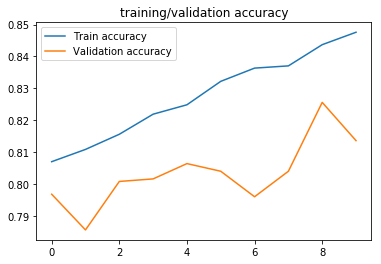

In [57]:
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.title('training/validation accuracy')
plt.show()

In [58]:
accuracy, loss = validate(model, test_loader, criterion)
print(f'After augmentation Test Loss: {loss:.4f}, Accuracy: {accuracy:.3f}')

After augmentation Test Loss: 0.4209, Accuracy: 0.815


#### Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение.

In [60]:
from torchvision import models
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 30)

In [63]:
ds = ConcatDataset([train_dataset, aug_dataset])
resnet_loader = DataLoader(ds, batch_size = 32, shuffle=True, num_workers=4)

In [64]:
train_acc, val_acc = train(model, resnet_loader, val_loader, 10, optimizer, criterion, scheduler)









  0%|          | 0/10 [00:00<?, ?it/s]







 10%|█         | 1/10 [02:53<26:00, 173.34s/it]

[Epoch 1/10] Train Loss: 0.2301, Accuracy: 0.904; Val Loss: 0.1713, Accuracy: 0.922










 20%|██        | 2/10 [05:51<23:17, 174.65s/it]

[Epoch 2/10] Train Loss: 0.1300, Accuracy: 0.948; Val Loss: 0.1156, Accuracy: 0.962










 30%|███       | 3/10 [08:48<20:28, 175.47s/it]

[Epoch 3/10] Train Loss: 0.0898, Accuracy: 0.965; Val Loss: 0.1253, Accuracy: 0.954










 40%|████      | 4/10 [11:45<17:36, 176.06s/it]

[Epoch 4/10] Train Loss: 0.0660, Accuracy: 0.975; Val Loss: 0.1657, Accuracy: 0.941










 50%|█████     | 5/10 [14:36<14:32, 174.56s/it]

[Epoch 5/10] Train Loss: 0.0554, Accuracy: 0.980; Val Loss: 0.1920, Accuracy: 0.948










 60%|██████    | 6/10 [17:34<11:42, 175.51s/it]

[Epoch 6/10] Train Loss: 0.0455, Accuracy: 0.982; Val Loss: 0.1520, Accuracy: 0.950










 70%|███████   | 7/10 [20:31<08:47, 175.94s/it]

[Epoch 7/10] Train Loss: 0.0334, Accuracy: 0.988; Val Loss: 0.1390, Accuracy: 0.954










 80%|████████  | 8/10 [23:29<05:53, 176.52s/it]

[Epoch 8/10] Train Loss: 0.0251, Accuracy: 0.991; Val Loss: 0.1584, Accuracy: 0.957










 90%|█████████ | 9/10 [26:29<02:57, 177.46s/it]

[Epoch 9/10] Train Loss: 0.0246, Accuracy: 0.992; Val Loss: 0.1353, Accuracy: 0.958










100%|██████████| 10/10 [29:27<00:00, 177.78s/it]

[Epoch 10/10] Train Loss: 0.0209, Accuracy: 0.993; Val Loss: 0.2067, Accuracy: 0.950


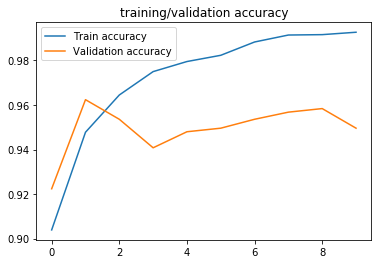

In [81]:
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.title('training/validation accuracy')
plt.show()

In [66]:
accuracy, loss = validate(model, test_loader, criterion)
print(f'ResNet18 Test Loss: {loss:.4f}, Accuracy: {accuracy:.3f}')

ResNet18 Test Loss: 0.1693, Accuracy: 0.949


In [68]:
filename_pth = 'resnet18_catdog.pth'
torch.save(model.state_dict(), filename_pth)

In [75]:
files_labels = {os.path.join(train_dir, file_name): file_name for file_name in os.listdir(train_dir)}
test_data = pd.DataFrame.from_dict({'image_file': list(files_labels.keys()), 'label': list(files_labels.values())})
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_ds = CatDogDataset(test_data, transform = data_transform)
testloader = DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers=4)
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.cuda()
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_resnet18.csv', index=False)
    

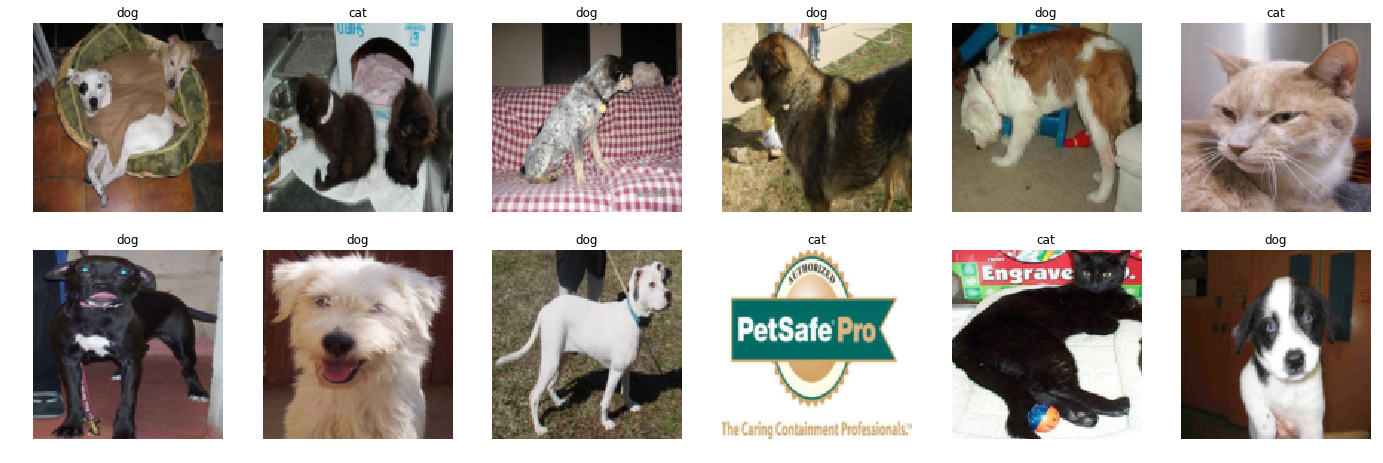

In [79]:
samples, _ = iter(testloader).next()
samples = samples.cuda()
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:12]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

### Вывод:
В данной лабораторной мы использовали сверточную нейронную сеть для реализации бинарного классификатора на наборе данных Cats/Dogs. Использовали аугментацию данных и предаточное обучение.